In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Generate test image

In [2]:
def eulerAnglesToRotationMatrix(theta):
    R_x = np.array([[1, 0, 0], [0, np.cos(theta[0]), -np.sin(theta[0])],
                    [0, np.sin(theta[0]),
                     np.cos(theta[0])]])
    R_y = np.array([[np.cos(theta[1]), 0,
                     np.sin(theta[1])], [0, 1, 0],
                    [-np.sin(theta[1]), 0,
                     np.cos(theta[1])]])
    R_z = np.array([[np.cos(theta[2]), -np.sin(theta[2]), 0],
                    [np.sin(theta[2]), np.cos(theta[2]), 0], [0, 0, 1]])
    R = np.dot(R_z, np.dot(R_y, R_x))
    return R


In [3]:
def warp_angle(angle):
    return (angle + np.pi) % (2 * np.pi) - np.pi

## Generate 3d points

In [59]:
class Laptop(object):
    @staticmethod
    def get_3d_points(a, b, alpha):
        points = [
            [a / 2, b / 2, 0],
            [a / 2, -b / 2, 0],
            [-a / 2, b / 2, 0],
            [-a / 2, -b / 2, 0],
            [-a / 2 + a * np.cos(alpha), b / 2, a * np.sin(alpha)],
            [-a / 2 + a * np.cos(alpha), -b / 2, a * np.sin(alpha)]
        ]
        return np.array(points)
    @staticmethod
    def draw_line(p1, p2, c):
        plt.plot((p1[0], p2[0]), (p1[1], p2[1]), c=c)
    @staticmethod
    def draw(ps):
        Laptop.draw_line(ps[0], ps[2], c="b")
        Laptop.draw_line(ps[0], ps[1], c="b")
        Laptop.draw_line(ps[3], ps[1], c="b")
        Laptop.draw_line(ps[2], ps[3], c="b")
        Laptop.draw_line(ps[3], ps[5], c="r")
        Laptop.draw_line(ps[5], ps[4], c="r")
        Laptop.draw_line(ps[4], ps[2], c="r")
        
    @staticmethod
    def get_2d_points(T, L, K=None, R=None):
        if R is None:
            x, y, z, ax, ay, az = T
            R = eulerAnglesToRotationMatrix((ax, ay, az))
        else:
            x, y, z = T
        if K is None:
            K = np.array([[400, 0, 200], [0, 400, 200], [0, 0, 1]])
        t = np.array([[x, y, z]]).T
        M = np.concatenate((R, t), axis=1)
        feature_points_3d = Laptop.get_3d_points(*L)
        feature_points_3d_hom = np.concatenate((feature_points_3d.T, np.ones((1, feature_points_3d.shape[0]))), axis=0)
        feature_points_2d_hom = K @ M @ feature_points_3d_hom
        feature_points_2d = (feature_points_2d_hom[:2] / feature_points_2d_hom[2]).T
        return feature_points_2d

In [5]:
A = 0.3
B = 0.5
Alpha = np.pi / 2 - 0.5
L0 = np.array([A, B, Alpha])
K = np.array([[400, 0, 200], [0, 400, 200], [0, 0, 1]])
T0 = np.array([0, 0, 1.6, 1.1, 2.4, 2.9])

In [6]:
Laptop.get_3d_points(*L0)

array([[ 0.15      ,  0.25      ,  0.        ],
       [ 0.15      , -0.25      ,  0.        ],
       [-0.15      ,  0.25      ,  0.        ],
       [-0.15      , -0.25      ,  0.        ],
       [-0.00617234,  0.25      ,  0.26327477],
       [-0.00617234, -0.25      ,  0.26327477]])

## generate 2d points

In [7]:
Laptop.get_2d_points(T0, L0, K)

array([[180.25830957, 169.85489225],
       [267.50588986, 211.4582431 ],
       [126.9625711 , 187.6028504 ],
       [214.1203367 , 221.56142976],
       [140.86194436, 251.51763594],
       [234.90816438, 276.72117412]])

In [8]:
def draw_3d_points(T, L, K=None):
    feature_points_2d = Laptop.get_2d_points(T, L, K)
    Laptop.draw(feature_points_2d)
    plt.xlim(0, 1080)
    plt.ylim(0, 600)

In [9]:
draw_3d_points(T0, L0)

In [10]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [84]:
file = open("camera_calibration.txt")
s = file.readline()
s = list(map(int, s.split(", ")))
w = s[0]
h = s[1]
K = np.array([[s[2] / 10, 0, s[4] / 10], [0, s[3] / 10, s[5] / 10] , [0, 0, 1]])
K = np.array([[s[2], 0, s[4]], [0, s[3], s[5]] , [0, 0, 1]])
# K = np.array([[s[2] / 10, 0, s[4]], [0, s[3] / 10, s[5]] , [0, 0, 1]])
K

array([[1236,    0,  917],
       [   0, 1208,  520],
       [   0,    0,    1]])

In [81]:
def interect_draw_3d_points(x, y, z, ax, ay, az):
    T = np.array([x, y, z, ax, ay, az])
    draw_3d_points(T, L0, K)
interact(interect_draw_3d_points, x=0., y=0., z=(0, 3.), ax=(0., 2 * np.pi), 
         ay=(0., 2 * np.pi), az=(0., 2 * np.pi), continuous_update=False);

interactive(children=(FloatSlider(value=0.0, description='x', max=1.0), FloatSlider(value=0.0, description='y'…

# Calculate 3d shape and position

In [13]:
import scipy.optimize

In [14]:
A = 0.3 + 0.05
B = 0.5 + 0.05
Alpha = np.pi / 2 - 0.5
L = np.array([A, B, Alpha])
K = np.array([[400, 0, 200], [0, 400, 200], [0, 0, 1]])
T = np.array([0, 0, 1.6, 1.1, 2.4, 2.9])

L0 = np.array([0.3, 0.5, np.pi / 2 - 0.01])
T0 = T.copy()
test_2d_points = Laptop.get_2d_points(T, L, K)
reg_lambda = np.array([100, 100, 2])

In [15]:
def cost_fun(x):
    T = x[:6]
    L = x[6:9]
    y_points = np.linalg.norm(Laptop.get_2d_points(T, L, K) - test_2d_points, axis=1)
    y_shape = reg_lambda * (L - L0)
    y_shape[2] = warp_angle(y_shape[2])
    return np.concatenate((y_points, y_shape), axis=0)

In [16]:
T0 = np.array([0, 0, 1, 0, 0, 0])
x0 = np.concatenate((T0, L0), axis=0)
res = scipy.optimize.least_squares(cost_fun, x0)

In [17]:
np.round(res.x[:6], 2)

array([ 0.  ,  0.  ,  1.42, -2.04,  0.72, -0.24])

In [18]:
np.round(res.x[6:10], 3)

array([0.305, 0.497, 1.093])

In [19]:
L

array([0.35      , 0.55      , 1.07079633])

In [20]:
T

array([0. , 0. , 1.6, 1.1, 2.4, 2.9])

In [21]:
draw_3d_points(res.x[:6], res.x[6:])

In [107]:
def find_laptop_position(keypoints, K):
#     assert type(keypoints) is dict
    assert K.shape == (3, 3)
    
#     ids = []
#     points = []
#     for id_, point in keypoints.items():
#         ids.append(id_)
#         points.append(point)      
#     ids = np.array(ids)
#     points = np.array(points)
#     assert len(points) > 2, "Not enouth points %d" % len(points)
    
    L0 = np.array([0.6, 0.5, np.pi / 2 - 0.01])
    T0 = np.array([0, 0, 1, np.pi /2 , 0, -np.pi / 2])
    reg_lambda = np.array([200, 200, 10])
    
#     points[:, 1] = 1080 - points[:, 1]
    
    def cost_fun(x):
        T = x[:6]
        L = x[6:9]
#         y_points = np.linalg.norm(Laptop.get_2d_points(T, L, K)[ids] - points, axis=1)
        y_points = np.linalg.norm(Laptop.get_2d_points(T, L, K) - keypoints, axis=1)
        y_shape = (L - L0)
        y_shape[2] = warp_angle(y_shape[2])
        y_shape = reg_lambda * y_shape
        return np.concatenate((y_points, y_shape), axis=0)
    
    x0 = np.concatenate((T0, L0), axis=0)
    res = scipy.optimize.least_squares(cost_fun, x0)
    print(res.fun)
    print(res.x)
    return eulerAnglesToRotationMatrix(res.x[3:6]), res.x[:3], res.x[6:]

In [24]:
find_laptop_position(test_2d_points, K)

(array([[ 0.72769184, -0.68210477, -0.07209487],
        [-0.18132989, -0.29268118,  0.93885952],
        [-0.66150137, -0.67012746, -0.33666769]]),
 array([1.27822475e-03, 5.84664898e-04, 1.42051099e+00]),
 array([0.30526638, 0.49691232, 1.09329259]))

# Real test

## Load keypoints

In [33]:
def swap(x, y):
    z = x
    x = y
    y = z
    return x, y

In [54]:
keypoints_data = np.load("all_keypoints.npy")
keypoints = keypoints_data.item()[0][0]
keypoints[5], keypoints[4] =  swap(keypoints[5], keypoints[4])
# keypoints = np.array(keypoints.values())
keypoints = np.array([keypoints[i] for i in range(6)])

## Load img

In [35]:
import sys
sys.path.remove("/opt/ros/kinetic/lib/python2.7/dist-packages")
import cv2

ValueError: list.remove(x): x not in list

In [36]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams["figure.dpi"] = 200

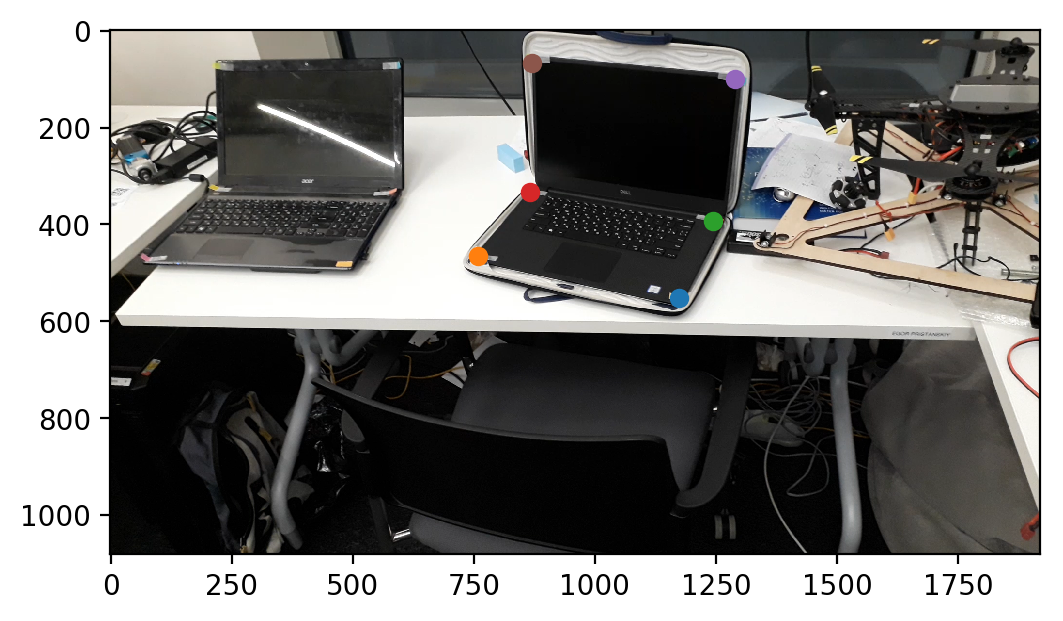

In [42]:
img = cv2.imread("../QRretriever/data_png/data/laptop1/0000.png")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
for i in range(6):
    plt.scatter(keypoints[i][0],keypoints[i][1])

In [105]:
T0 = np.array([0, 0, 1, np.pi /2 , 0, np.pi / 2])
T0

array([0.        , 0.        , 1.        , 1.57079633, 0.        ,
       1.57079633])

In [108]:
R, T, shape = find_laptop_position(keypoints, K)

[  6.90946927   2.90126264  10.33527654  16.34269724   5.01651939
  10.05514663 -22.87924341  18.75046486  -1.63482985]
[ 0.13688326 -0.13959741  1.83411675 -2.67214527  0.92348555 -4.11305816
  0.48560378  0.59375232  1.39731334]


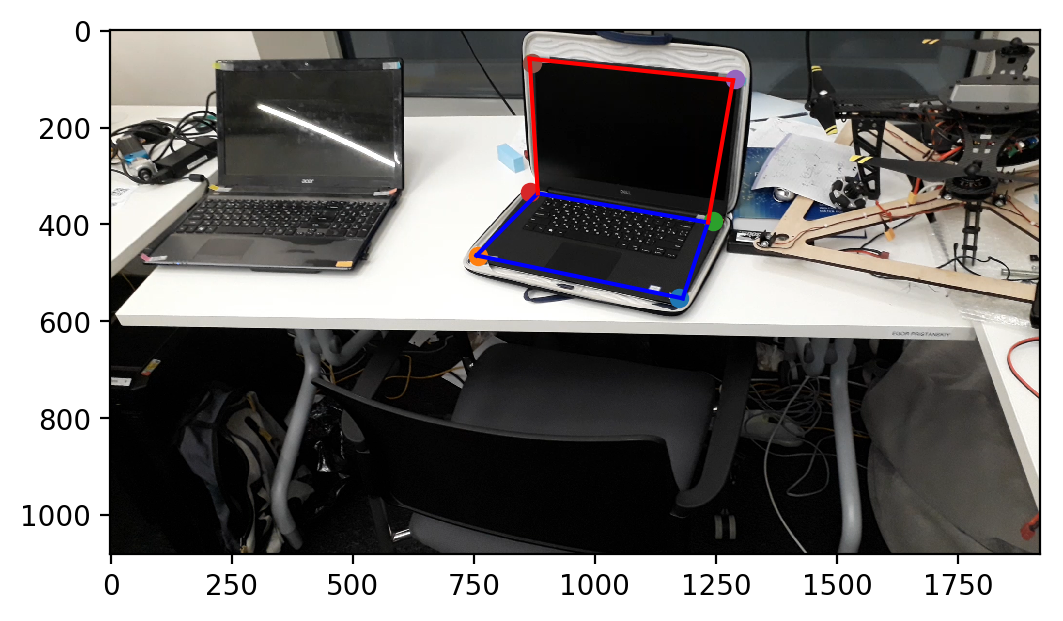

In [109]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
Laptop.draw(Laptop.get_2d_points(T, shape, K, R=R))
for i in range(6):
    plt.scatter(keypoints[i][0],keypoints[i][1])

In [110]:
shape

array([0.48560378, 0.59375232, 1.39731334])

In [111]:
R

array([[-0.34017076,  0.93995407,  0.02775256],
       [ 0.49794092,  0.20508405, -0.84261223],
       [-0.7977084 , -0.27281291, -0.53780519]])